# Chargement des libs

In [1]:
import sys
import os
import logging
import pandas as pd
import numpy as np
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import joblib
import warnings

warnings.filterwarnings('ignore')

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
logger = logging.getLogger(__name__)

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import clusters

# Collecte de données

In [2]:
db_path = "../data/xenty.db"
conn = sqlite3.connect(db_path)
query = "SELECT * FROM x_cryptos ORDER BY CASE WHEN market_cap_rank IS NULL THEN 999999 ELSE market_cap_rank END ASC"

df = pd.read_sql_query(query, conn)
conn.close()
print("📊 Dataset créé avec", len(df), "comptes crypto")
df.head()

📊 Dataset créé avec 7980 comptes crypto


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7856996,13,28760,"{""tweet-1947676712256352511"": {""created_at"": ""...",1313643968,1.0,1.753197e+09
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3885892,0,4385,"{""tweet-1947426361519575517"": {""created_at"": ""...",1390763724,2.0,1.753198e+09
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,539029,246,1763,"{""tweet-1943672677358506462"": {""created_at"": ""...",1415394150,3.0,1.752315e+09
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3154929,987,9120,"{""tweet-1943810539412435185"": {""created_at"": ""...",1356983139,4.0,1.752315e+09
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3859567,629,27214,"{""tweet-1943943436886757550"": {""created_at"": ""...",1539759563,5.0,1.752315e+09


# Nettoyage et préparation des données

In [3]:
# Fonction pour modifier le type de l'attribut views_count string -> int
def cast_views_count_to_int(post_json_str):
    if pd.isna(post_json_str):
        return post_json_str
    
    # Charger le JSON
    try:
        posts_dict = json.loads(post_json_str)
    except json.JSONDecodeError:
        # Si le JSON est invalide, retourner la valeur originale
        return post_json_str
    
    # Parcourir chaque tweet dans le dictionnaire
    for _, tweet_data in posts_dict.items():
        if 'views_count' in tweet_data:
            tweet_data['views_count'] = int(tweet_data.pop('views_count'))
    
    # Reconvertir en JSON string
    return json.dumps(posts_dict)

# Appliquer la fonction à la colonne posts
print("Début de la transformation...")
posts_before = json.loads(df.loc[0, 'posts'])
keys = posts_before.keys()
first_key = list(keys)[0] if keys else None
print(posts_before[first_key])
df['posts'] = df['posts'].apply(cast_views_count_to_int)
posts_after = json.loads(df.loc[0, 'posts'])
keys = posts_after.keys()
first_key = list(keys)[0] if keys else None
print(posts_after[first_key])
print("Transformation terminée!")

# Remplacer les valeurs manquantes par -1 et convertir en int
df['market_cap_rank'] = df['market_cap_rank'].fillna(-1).astype(int)
df['sync_at'] = df['sync_at'].fillna(0).astype(int)
df.tail()

Début de la transformation...
{'created_at': 'Tue Jul 22 15:14:48 +0000 2025', 'full_text': '£88,185.44', 'views_count': '2404', 'bookmark_count': 1, 'likes_count': 72, 'quote_count': 1, 'reply_count': 32, 'retweet_count': 13, 'comments': ['@Bitcoin Very good Bitcoin.\n\nCan I get 90k?', '', '@Bitcoin no £88K here, but 2K USDT up for grabs rn', '@Bitcoin WAGMI BITCOIN', '@Bitcoin Bitcoin holding strong ready for next move 💎', '@Bitcoin idk what that is', '@Bitcoin Send it higher', '@Bitcoin Jtkt', '@Bitcoin Bitcoin is trading around £88,185 right now. 🚀📈… Only way is up ⬆️', '@Bitcoin Higher', '', '@Bitcoin 🥵🥵🥵', '@Bitcoin https://t.co/oZAMIF7uv6', '@Bitcoin Somebody shout higher 🚀🚀 BTC', '@Bitcoin When 100k?', '@Bitcoin 🦾', '@Bitcoin $aaaBTC', '@Bitcoin Beautiful', '@Bitcoin https://t.co/AKTwvLaSL1', '@Bitcoin lfg bullish @Illiquid_nft', '@Bitcoin 🪐 🍂 🌸 🍂 @qdosahmed This guy hits the nail on the head!', '@Bitcoin Check out my TL if you like bitcoin 👀', '', '@Bitcoin Let’s do this ever

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
7975,1932619199731675136,CoinElonSolana,CoinElonSolana,,0,21,0,1,None,1749607321,-1,0
7976,1933488137613025280,Commentary ShibEstee,TheEsteeCoin,$ESTEE: The original $SHIB. The fan Meme coin ...,0,1659,135,102,None,1749814490,-1,0
7977,1934669424239497216,roadmap coin,roadmapcoin,$RDMP is the coin of empty promises on @boopdo...,0,534,3,35,None,1750096124,-1,0
7978,1935243794250690560,Trevee Quest (Prev. Paladin_vote),Paladin_vote,@Trevee_xyz,0,4,2,0,None,1750233055,-1,0
7979,1937579523253665792,ImmortalDAO Finance,ImmortalDAO_Fi,Immortal is a decentralized reserve currency p...,0,1,2,1,None,1750789942,-1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7980 non-null   object
 1   name              7979 non-null   object
 2   screen_name       7980 non-null   object
 3   description       7980 non-null   object
 4   is_blue_verified  7980 non-null   int64 
 5   followers_count   7980 non-null   int64 
 6   following_count   7980 non-null   int64 
 7   posts_count       7980 non-null   int64 
 8   posts             1101 non-null   object
 9   created_at        7980 non-null   int64 
 10  market_cap_rank   7980 non-null   int64 
 11  sync_at           7980 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 748.2+ KB


In [5]:
# Suppression des comptes sans posts
df = df.dropna(subset=['posts']).reset_index(drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1101 non-null   object
 1   name              1101 non-null   object
 2   screen_name       1101 non-null   object
 3   description       1101 non-null   object
 4   is_blue_verified  1101 non-null   int64 
 5   followers_count   1101 non-null   int64 
 6   following_count   1101 non-null   int64 
 7   posts_count       1101 non-null   int64 
 8   posts             1101 non-null   object
 9   created_at        1101 non-null   int64 
 10  market_cap_rank   1101 non-null   int64 
 11  sync_at           1101 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 103.3+ KB


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7856996,13,28760,"{""tweet-1947676712256352511"": {""created_at"": ""...",1313643968,1,1753197478
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3885892,0,4385,"{""tweet-1947426361519575517"": {""created_at"": ""...",1390763724,2,1753197715
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,539029,246,1763,"{""tweet-1943672677358506462"": {""created_at"": ""...",1415394150,3,1752314758
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3154929,987,9120,"{""tweet-1943810539412435185"": {""created_at"": ""...",1356983139,4,1752314783
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3859567,629,27214,"{""tweet-1943943436886757550"": {""created_at"": ""...",1539759563,5,1752314808


In [6]:
df_filtered = df.copy()

# Filtre les tweets invalides
"""
Supprimer les retweets/repost car pas d'informations sur les interactions
Permet la mesure des interactions avec contenu original.
Supprimer les tweets sans views_count mais avec interactions
"""
def filter_valid_tweets(posts_json):
    posts_dict = json.loads(posts_json)
    
    filtered = {}
    for tweet_id, tweet_data in posts_dict.items():
        if (tweet_data.get('likes_count', 0) == 0 and 
            tweet_data.get('quote_count', 0) == 0 and 
            tweet_data.get('reply_count', 0) == 0) or (
                tweet_data.get('views_count', 0) == 0 and 
                (tweet_data.get('reply_count', 0) != 0 or 
                tweet_data.get('retweet_count', 0) != 0 or 
                tweet_data.get('likes_count', 0) != 0)) :
            continue
        filtered[tweet_id] = tweet_data
    
    return filtered

# Appliquer le filtre
df_filtered["filtered_posts"] = df_filtered["posts"].apply(filter_valid_tweets)
# df_filtered.drop(columns=["posts"], inplace=True)
#print(df["filtered_posts"])

# posts = df_filtered.loc[0, 'filtered_posts']
# print(len(posts))

# Calculer le nombre de tweets dans chaque entrée de posts
tweet_counts_original = df_filtered['posts'].apply(lambda x: len(json.loads(x)))
tweet_counts_filtered = df_filtered['filtered_posts'].apply(lambda x: len(x))

df_filtered['tweet_counts_original'] = tweet_counts_original
df_filtered['tweet_counts_filtered'] = tweet_counts_filtered

# Remove all row with tweet_counts_filtered = 0
df_filtered = df_filtered[df_filtered['tweet_counts_filtered'] > 0].reset_index(drop=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1075 non-null   object
 1   name                   1075 non-null   object
 2   screen_name            1075 non-null   object
 3   description            1075 non-null   object
 4   is_blue_verified       1075 non-null   int64 
 5   followers_count        1075 non-null   int64 
 6   following_count        1075 non-null   int64 
 7   posts_count            1075 non-null   int64 
 8   posts                  1075 non-null   object
 9   created_at             1075 non-null   int64 
 10  market_cap_rank        1075 non-null   int64 
 11  sync_at                1075 non-null   int64 
 12  filtered_posts         1075 non-null   object
 13  tweet_counts_original  1075 non-null   int64 
 14  tweet_counts_filtered  1075 non-null   int64 
dtypes: int64(9), object(6

In [7]:
# Statistiques descriptives
stats_df = pd.DataFrame({
    'Posts originaux': df['posts'].apply(lambda x: len(json.loads(x))).describe(),
    'Posts filtrés': df_filtered['tweet_counts_filtered'].describe()
})

print(f"{tweet_counts_original.sum()} tweets au total {tweet_counts_filtered.sum()} après nettoyage")
print("\nStatistiques sur le nombre de tweets par entrée:")
# Calculer la réduction moyenne du nombre de tweets après filtrage
reduction = ((tweet_counts_original - tweet_counts_filtered) / tweet_counts_original * 100).mean()
print(f"Réduction moyenne du nombre de tweets après filtrage: {reduction:.2f}%")
display(stats_df)
df_filtered.head()

17932 tweets au total 12713 après nettoyage

Statistiques sur le nombre de tweets par entrée:
Réduction moyenne du nombre de tweets après filtrage: 28.74%


,Posts originaux,Posts filtrés
count,1101.000000,1075.000000
mean,16.287012,11.826047
std,4.001284,4.977273
min,1.000000,1.000000
25%,14.000000,8.000000
50%,18.000000,12.000000
75%,19.000000,16.000000
max,20.000000,20.000000


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7856996,13,28760,"{""tweet-1947676712256352511"": {""created_at"": ""...",1313643968,1,1753197478,{'tweet-1947676712256352511': {'created_at': '...,20,17
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3885892,0,4385,"{""tweet-1947426361519575517"": {""created_at"": ""...",1390763724,2,1753197715,{'tweet-1947413177131798789': {'created_at': '...,16,5
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,539029,246,1763,"{""tweet-1943672677358506462"": {""created_at"": ""...",1415394150,3,1752314758,{'tweet-1943672677358506462': {'created_at': '...,20,9
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3154929,987,9120,"{""tweet-1943810539412435185"": {""created_at"": ""...",1356983139,4,1752314783,{'tweet-1943810539412435185': {'created_at': '...,20,7
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3859567,629,27214,"{""tweet-1943943436886757550"": {""created_at"": ""...",1539759563,5,1752314808,{'tweet-1943943436886757550': {'created_at': '...,17,16


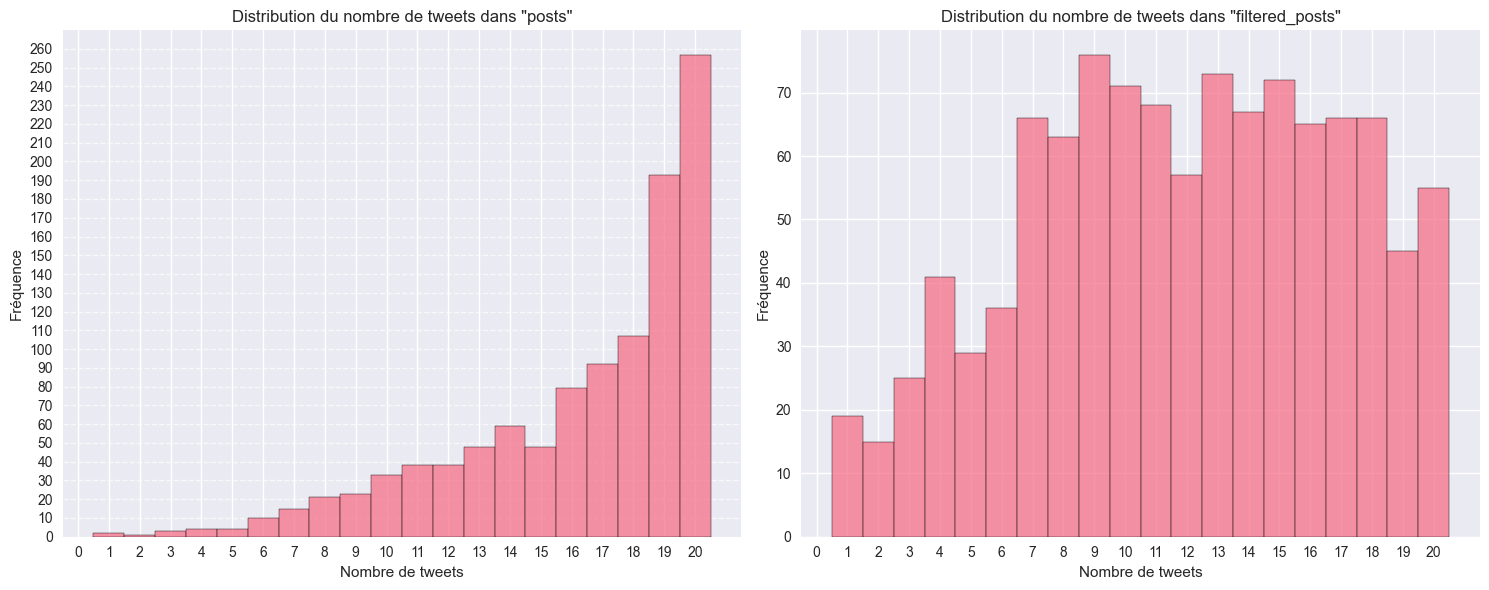

In [8]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Déterminer la plage des données pour définir les bins
max_count = max(df_filtered['tweet_counts_original'].max(), df_filtered['tweet_counts_filtered'].max())
bins = np.arange(-0.5, max_count + 1.5, 1)  # Bins centrés sur les entiers

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogramme pour les posts initiaux
sns.histplot(df_filtered['tweet_counts_original'], bins=bins, kde=False, ax=axes[0], discrete=True)
axes[0].set_title('Distribution du nombre de tweets dans "posts"')
axes[0].set_xlabel('Nombre de tweets')
axes[0].set_ylabel('Fréquence')
axes[0].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Amélioration de la précision de l'axe vertical
y_max = axes[0].get_ylim()[1]
axes[0].set_yticks(np.arange(0, int(y_max) + 1, 10))  # Ticks entiers pour chaque valeur de fréquence
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Ajouter une grille horizontale

# Histogramme pour les posts filtrés
sns.histplot(df_filtered['tweet_counts_filtered'], bins=bins, kde=False, ax=axes[1], discrete=True)
axes[1].set_title('Distribution du nombre de tweets dans "filtered_posts"')
axes[1].set_xlabel('Nombre de tweets')
axes[1].set_ylabel('Fréquence')
axes[1].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Si le max_count est grand, limitons les ticks pour éviter l'encombrement
if max_count > 20:
    for ax in axes:
        ax.set_xticks(np.arange(0, max_count + 1, 2))  # Ticks tous les 2 entiers

plt.tight_layout()
plt.show()

## Normalisation des features

In [9]:
features = [
    # 'followers_count',
    # 'following_count',
    # 'posts_count',
    # 'market_cap_rank',    
    # 'tweet_counts_filtered',
    # 'likes_per_follower',
    # 'retweets_per_follower',
    # 'replies_per_follower',
    # 'views_per_follower',
    # 'bookmarks_per_views',
    'likes_per_views',
    'retweets_per_views',
    'replies_per_views'
]

In [10]:
def calculate_view_normalized_metric(posts, metric_name):
    """
    Calculates the rate of a metric relative to the total number of views.
    """
    if not posts:
        return 0
    
    total_metric = sum(post.get(metric_name, 0) for post in posts.values())
    total_views = sum(post.get('views_count', 0) for post in posts.values())
    
    if total_views == 0:
        return 0
    
    return total_metric / total_views
    
# Create the new view-normalized feature columns
df_filtered['likes_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'likes_count'))
df_filtered['retweets_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'retweet_count'))
df_filtered['replies_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'reply_count'))
df_filtered['bookmarks_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'bookmark_count'))
df_filtered.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered,likes_per_views,retweets_per_views,replies_per_views,bookmarks_per_views
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7856996,13,28760,"{""tweet-1947676712256352511"": {""created_at"": ""...",1313643968,1,1753197478,{'tweet-1947676712256352511': {'created_at': '...,20,17,0.015097,0.003478,0.001752,0.000495
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3885892,0,4385,"{""tweet-1947426361519575517"": {""created_at"": ""...",1390763724,2,1753197715,{'tweet-1947413177131798789': {'created_at': '...,16,5,0.010334,0.001641,0.000856,0.000628
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,539029,246,1763,"{""tweet-1943672677358506462"": {""created_at"": ""...",1415394150,3,1752314758,{'tweet-1943672677358506462': {'created_at': '...,20,9,0.004769,0.000994,0.000816,0.000272
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3154929,987,9120,"{""tweet-1943810539412435185"": {""created_at"": ""...",1356983139,4,1752314783,{'tweet-1943810539412435185': {'created_at': '...,20,7,0.008579,0.002270,0.000332,0.000397
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3859567,629,27214,"{""tweet-1943943436886757550"": {""created_at"": ""...",1539759563,5,1752314808,{'tweet-1943943436886757550': {'created_at': '...,17,16,0.006359,0.001659,0.004532,0.000182


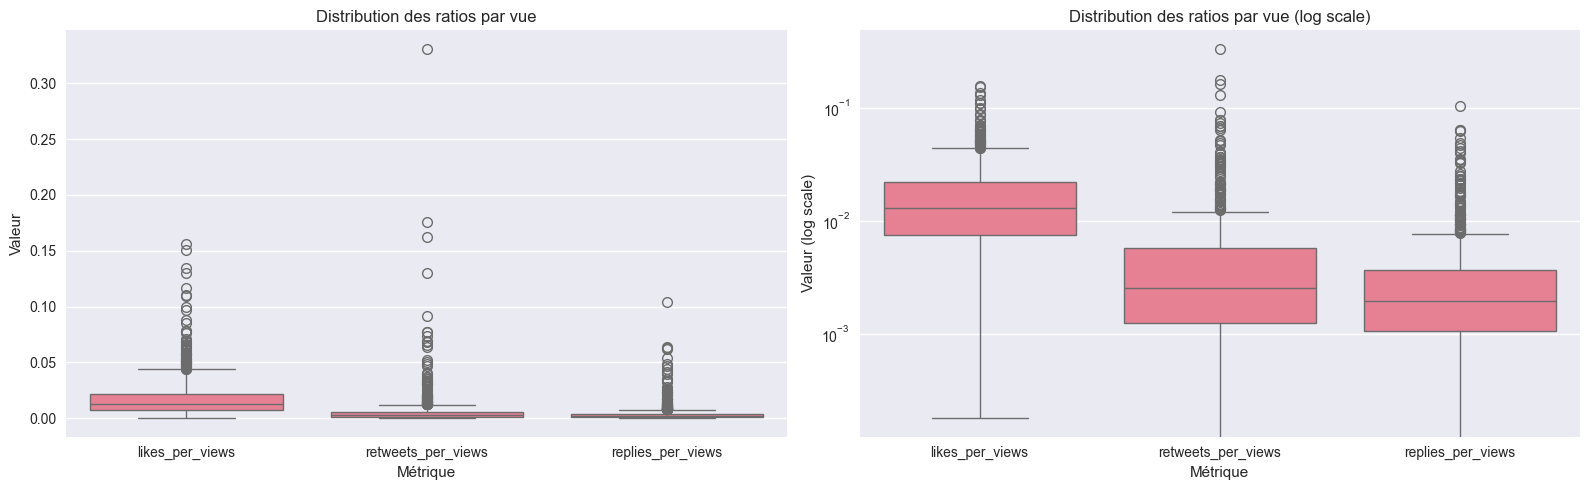

In [11]:
# Transformation du dataframe en format long
df_melted = df_filtered[features].melt(var_name='metric', value_name='value')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Premier graphique (échelle normale)
sns.boxplot(data=df_melted, x='metric', y='value', ax=axes[0])
axes[0].set_title("Distribution des ratios par vue")
axes[0].set_xlabel("Métrique")
axes[0].set_ylabel("Valeur")

# Deuxième graphique (échelle logarithmique)
sns.boxplot(data=df_melted, x='metric', y='value', ax=axes[1])
axes[1].set_title("Distribution des ratios par vue (log scale)")
axes[1].set_xlabel("Métrique")
axes[1].set_ylabel("Valeur (log scale)")
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


# Sélection de l'algorithme et du modèle


📈 Features d'engagement créées:
       likes_per_views  retweets_per_views  replies_per_views
count      1075.000000         1075.000000        1075.000000
mean          0.017607            0.005868           0.003733
std           0.016570            0.015412           0.006794
min           0.000181            0.000000           0.000000
25%           0.007551            0.001252           0.001068
50%           0.013065            0.002542           0.001974
75%           0.022046            0.005731           0.003715
max           0.156017            0.330870           0.104388

Test avec 2 clusters



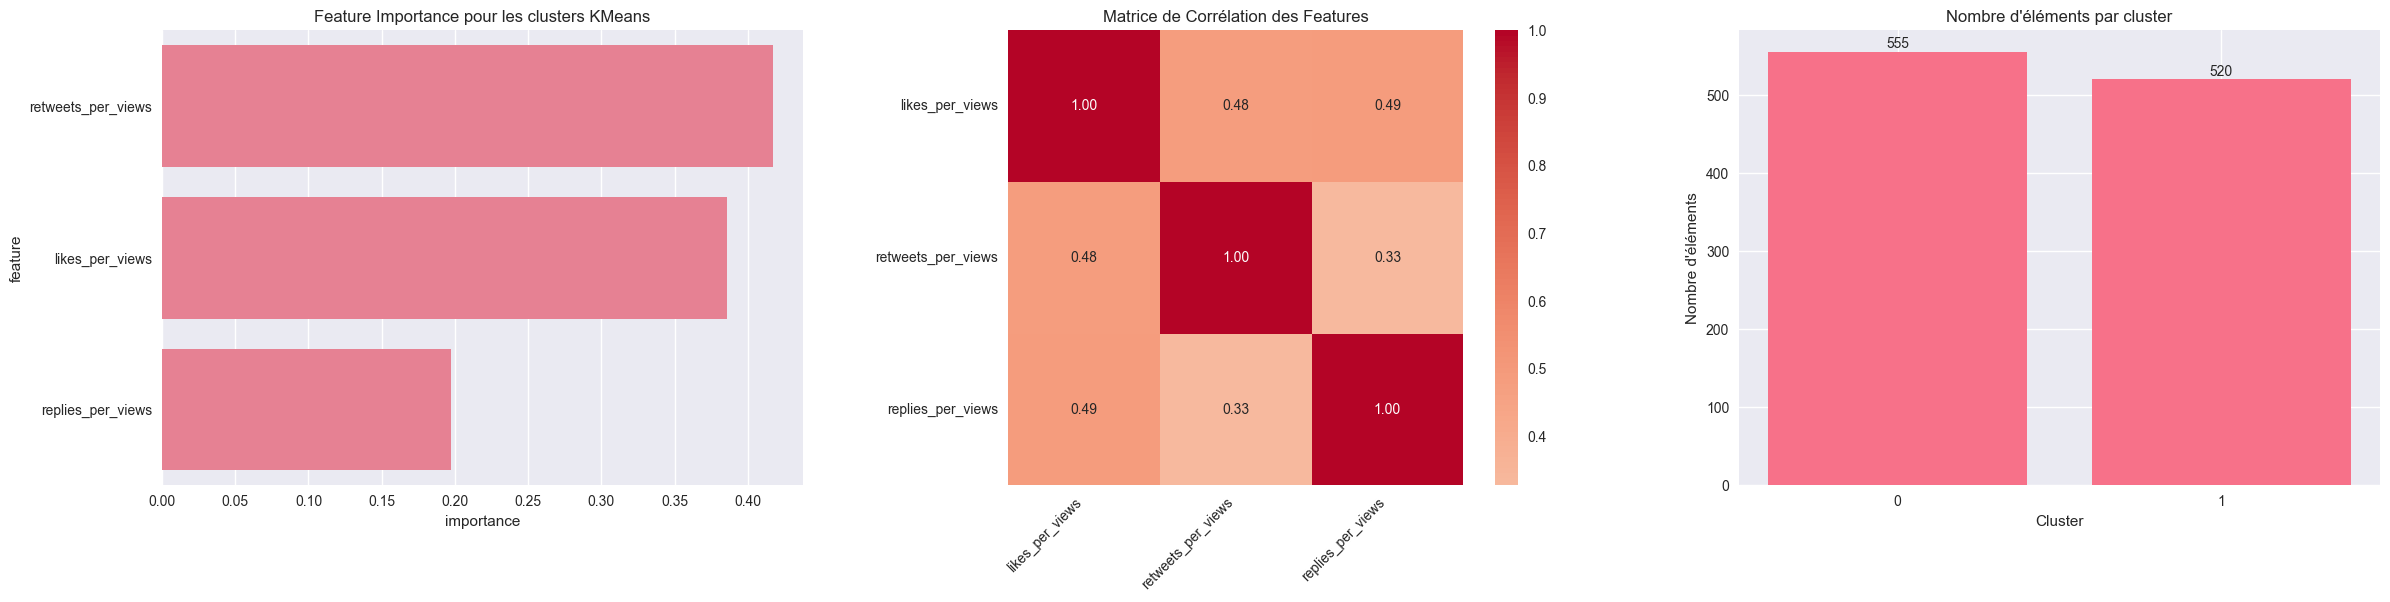

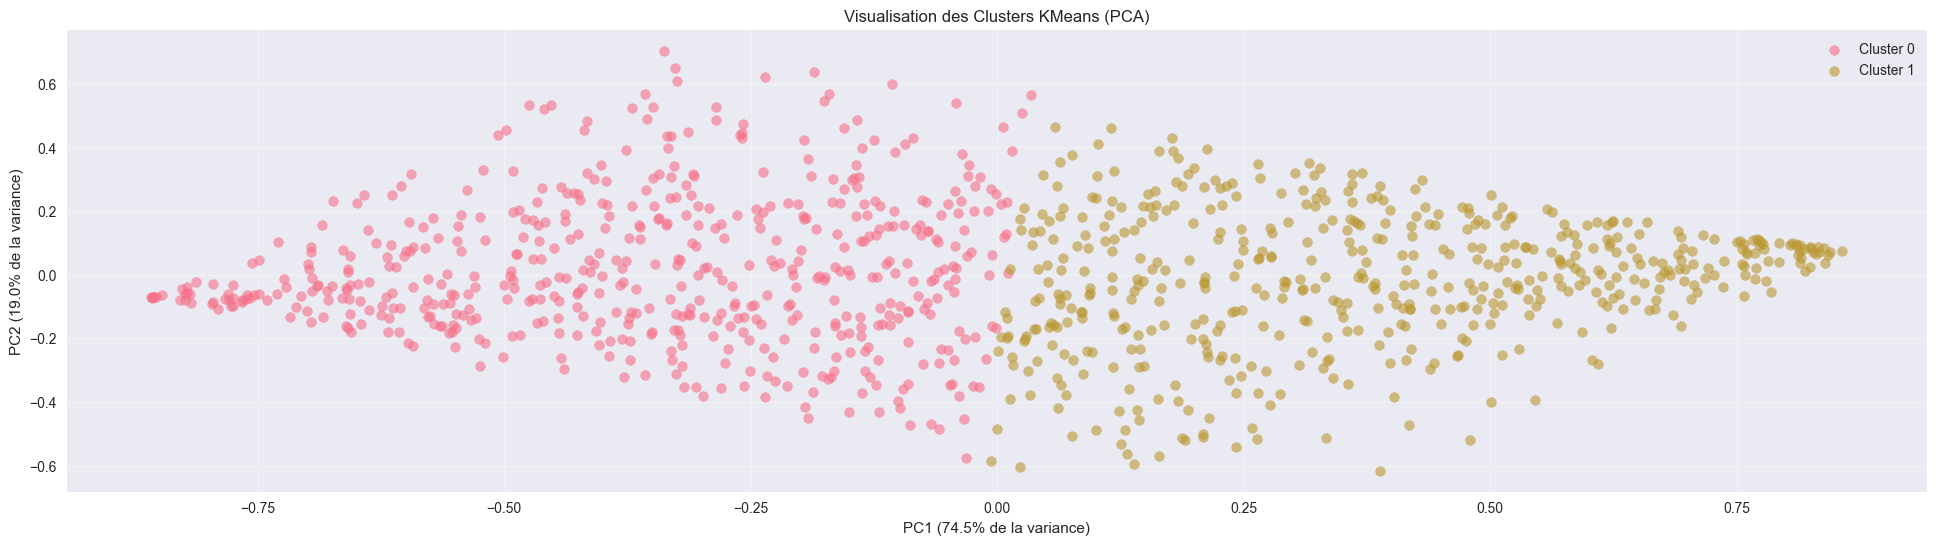


Test avec 3 clusters



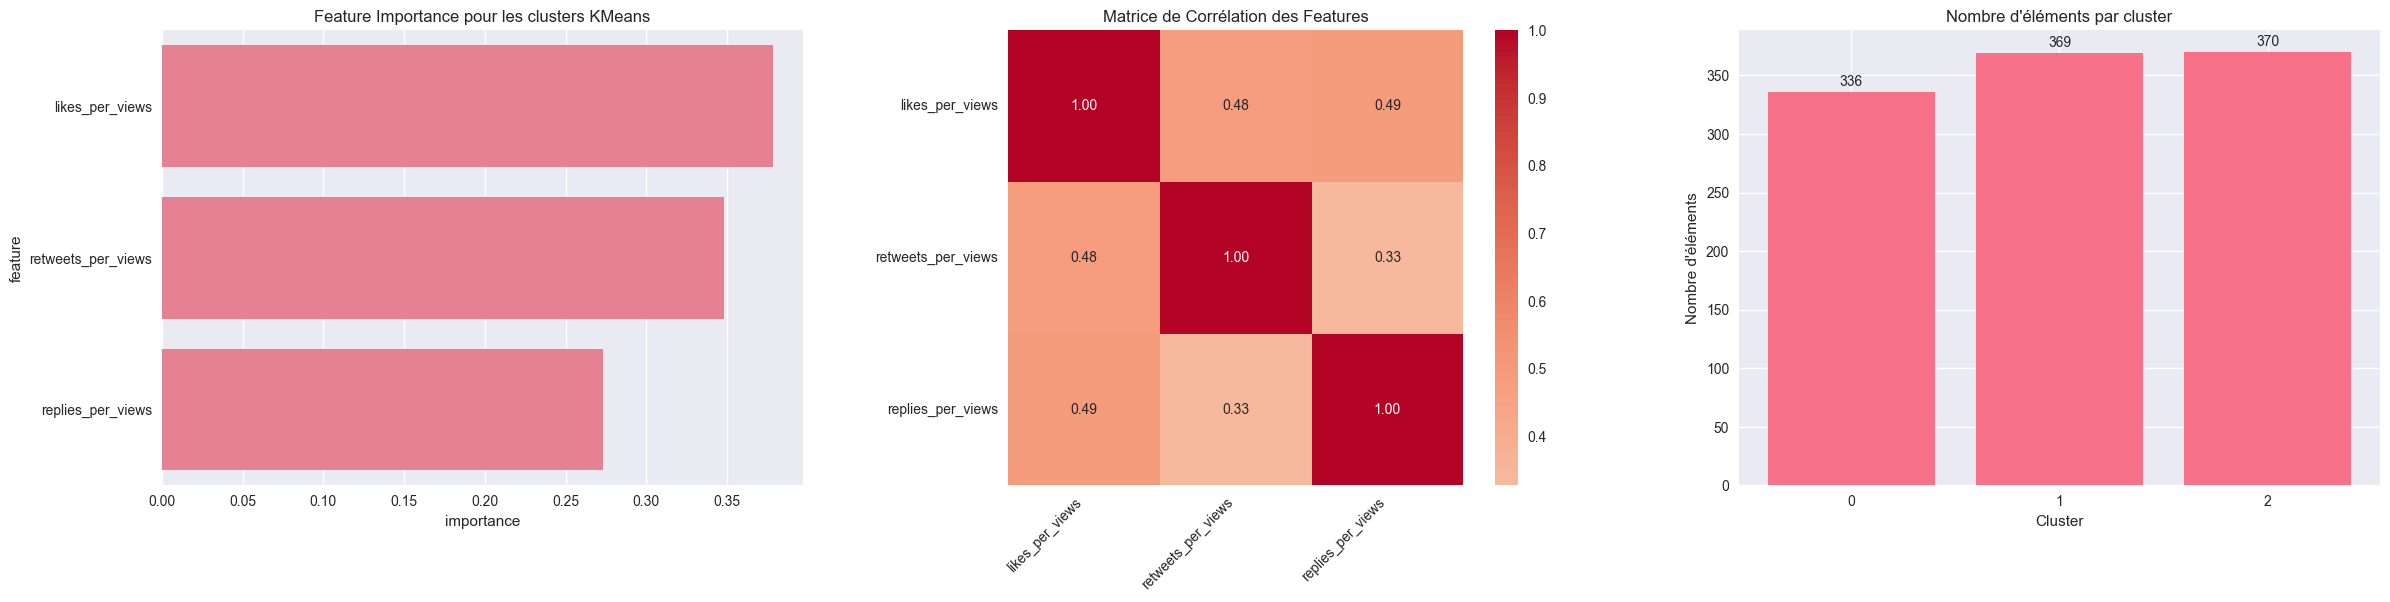

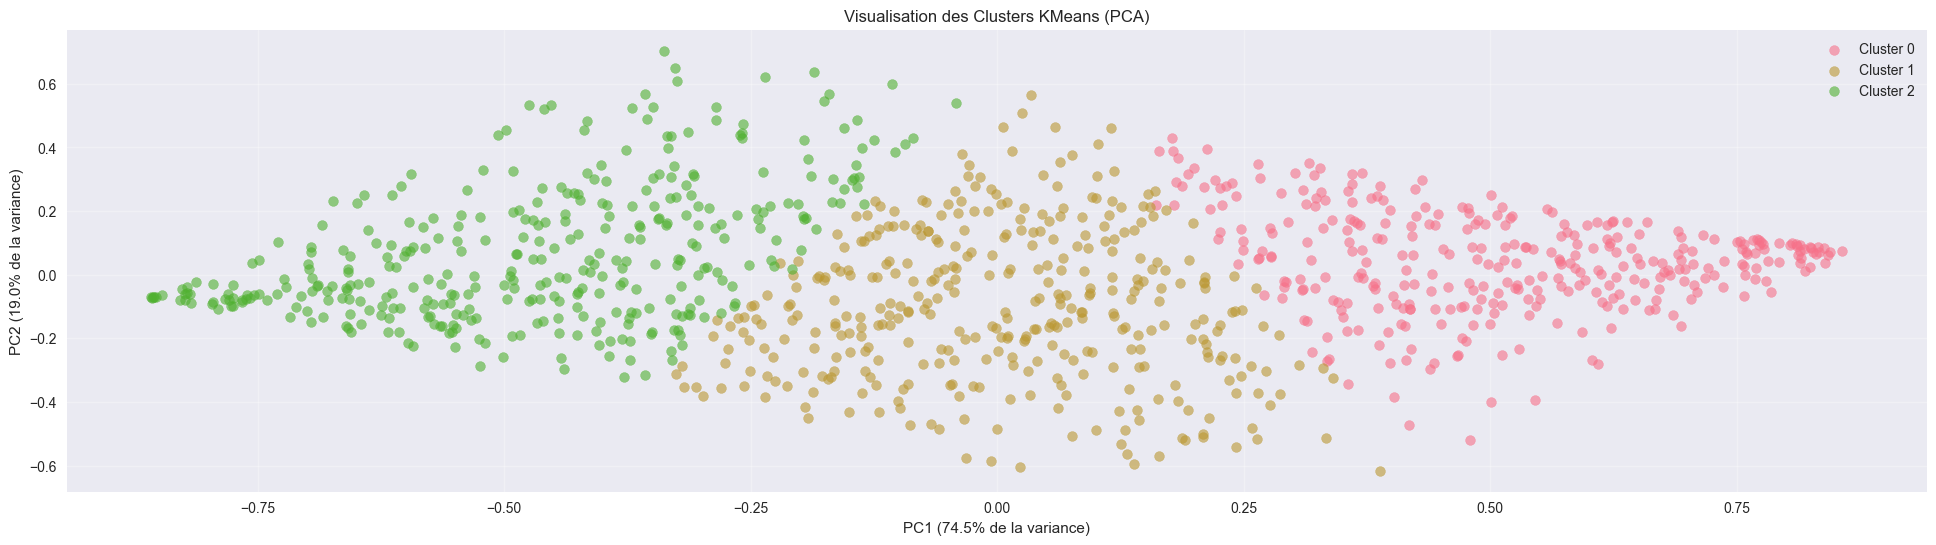


Test avec 4 clusters



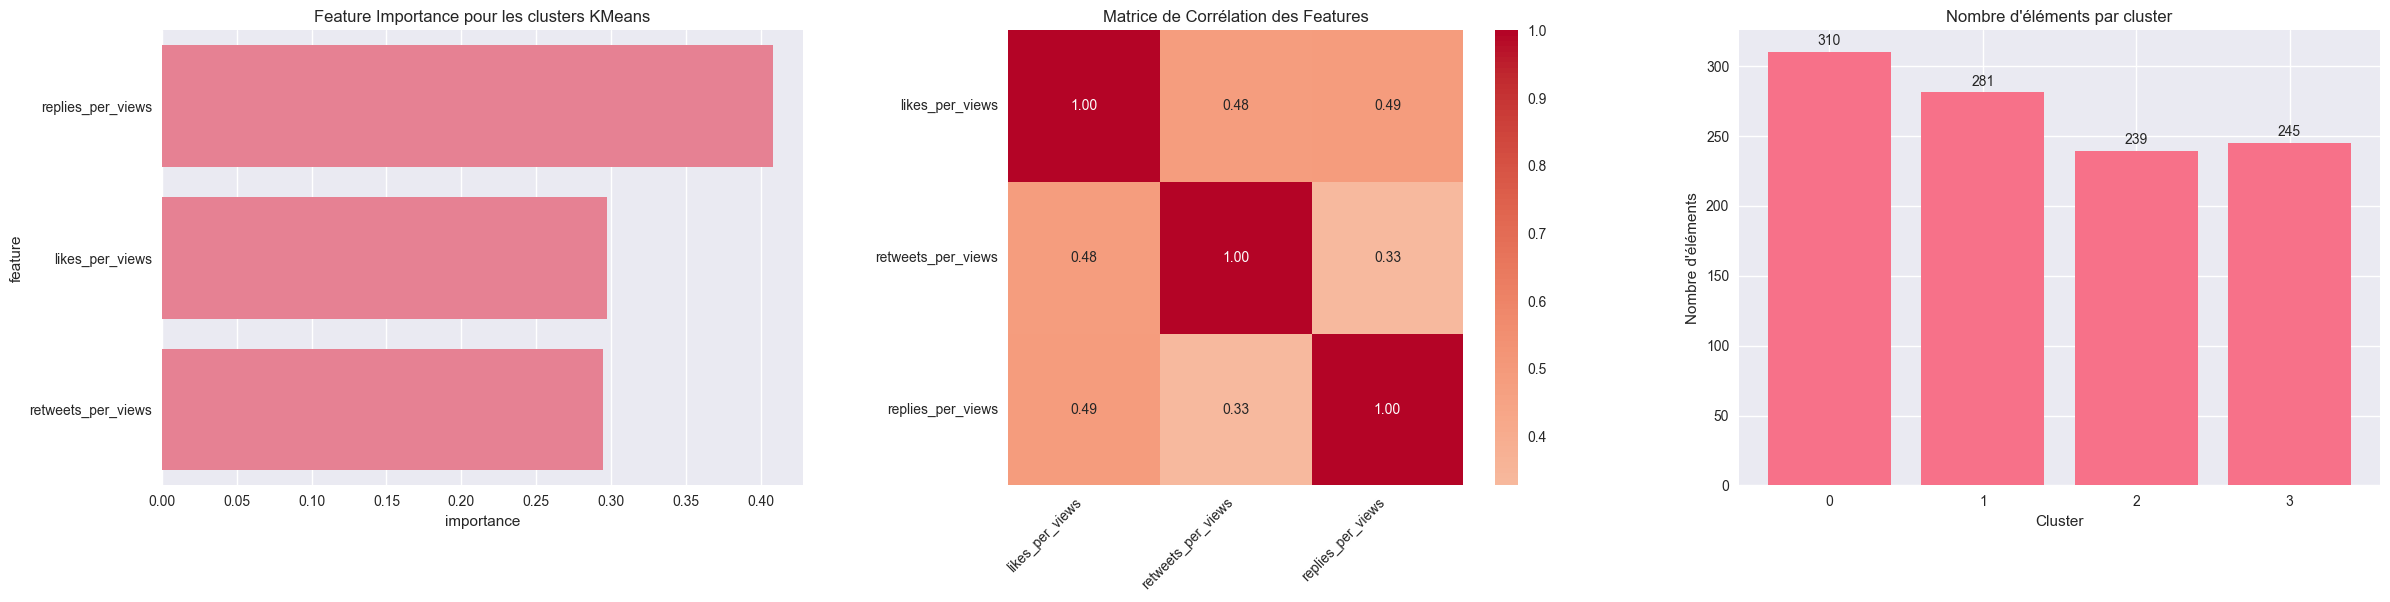

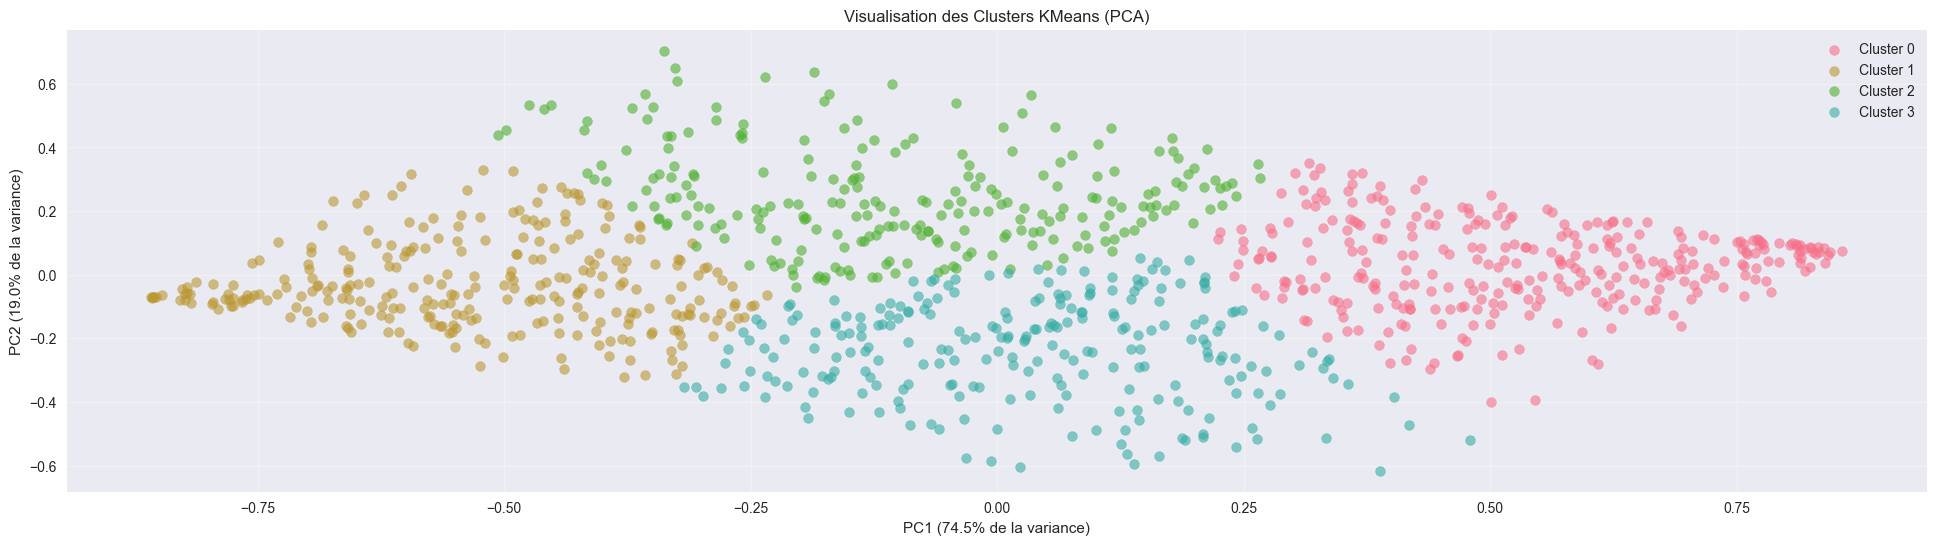


Test avec 5 clusters



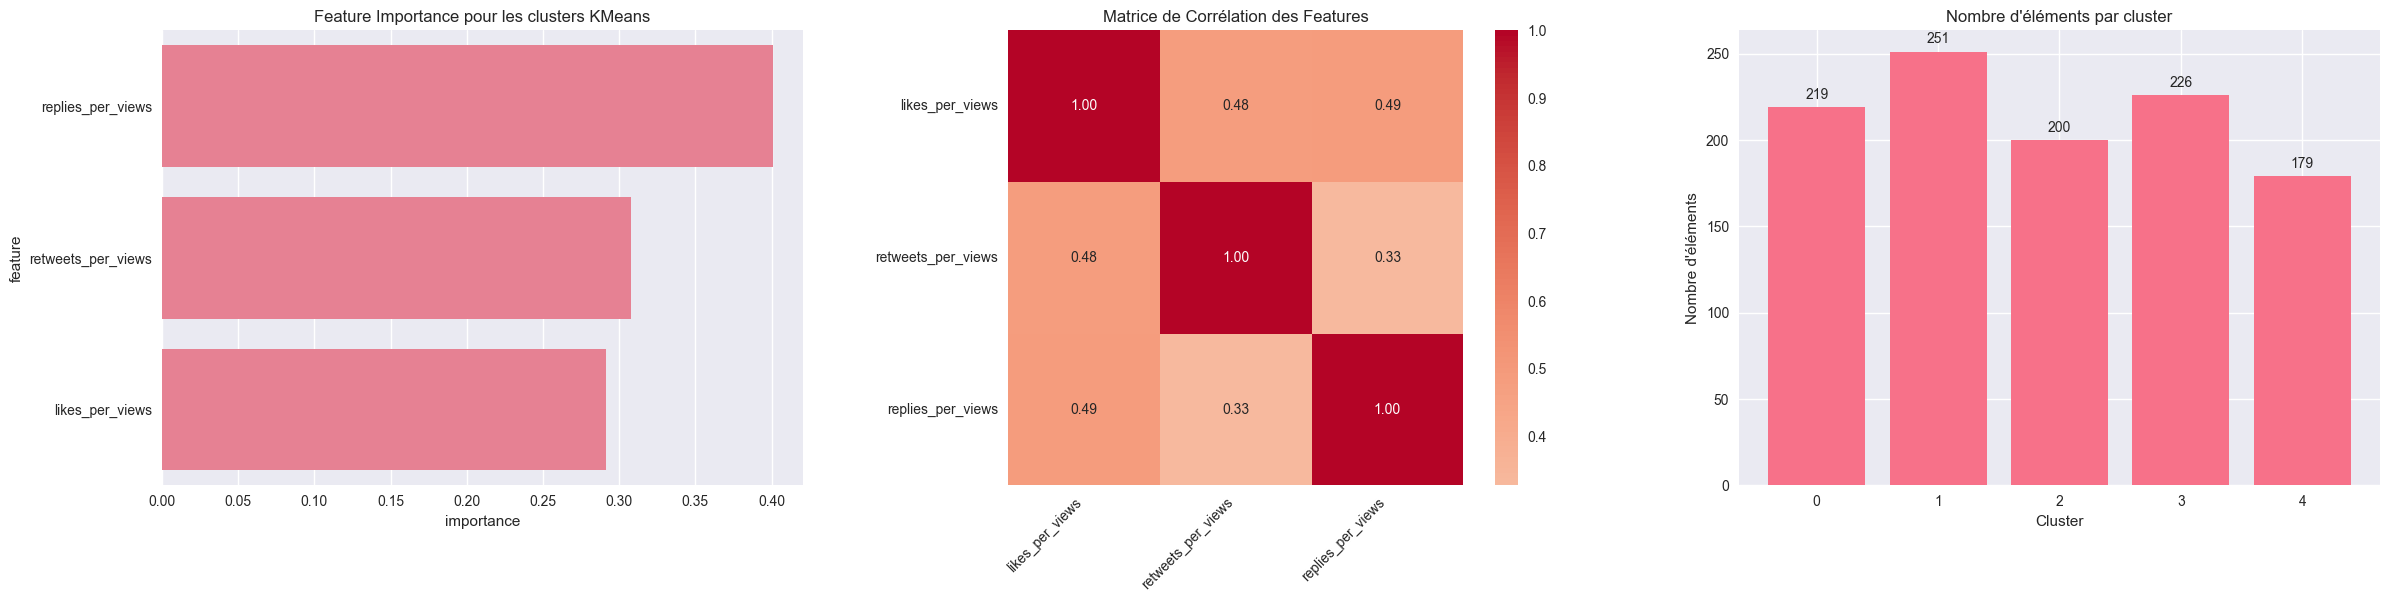

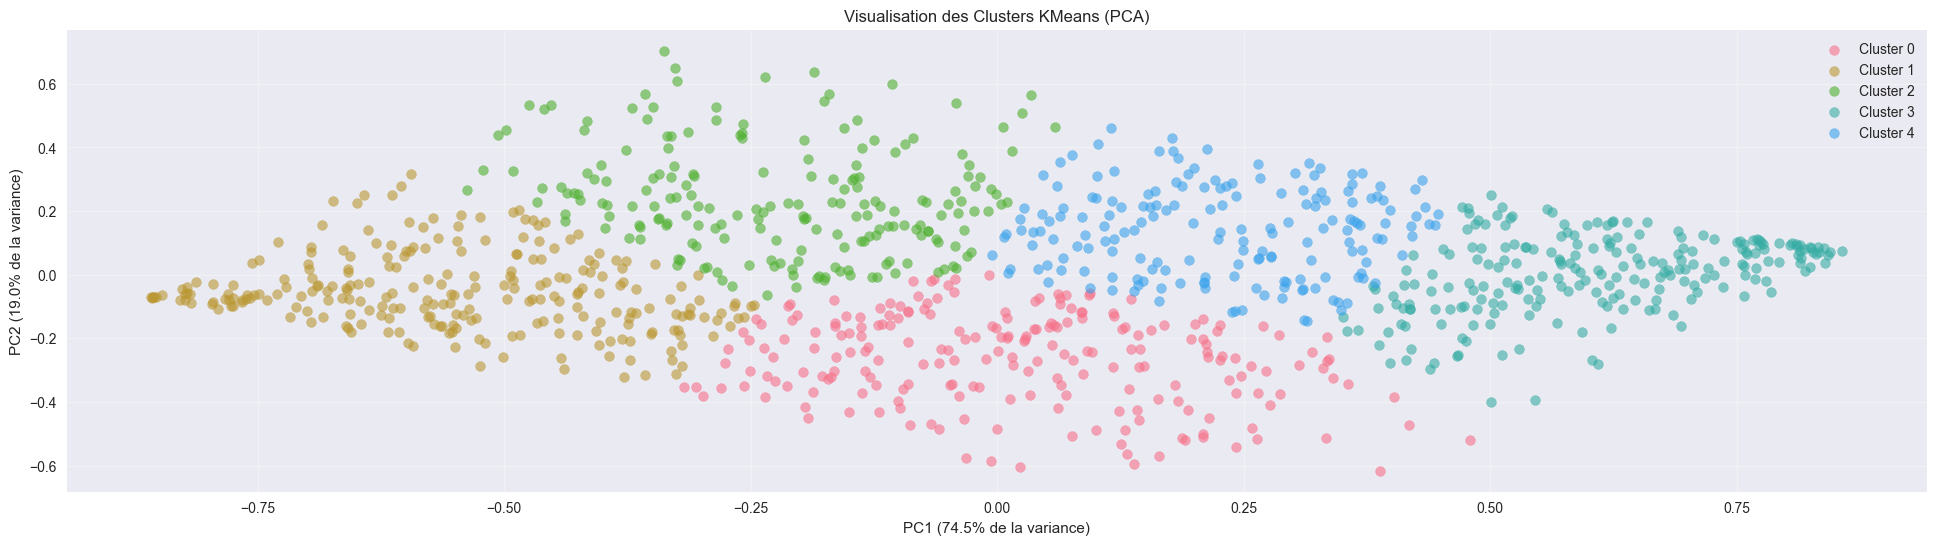


Test avec 6 clusters



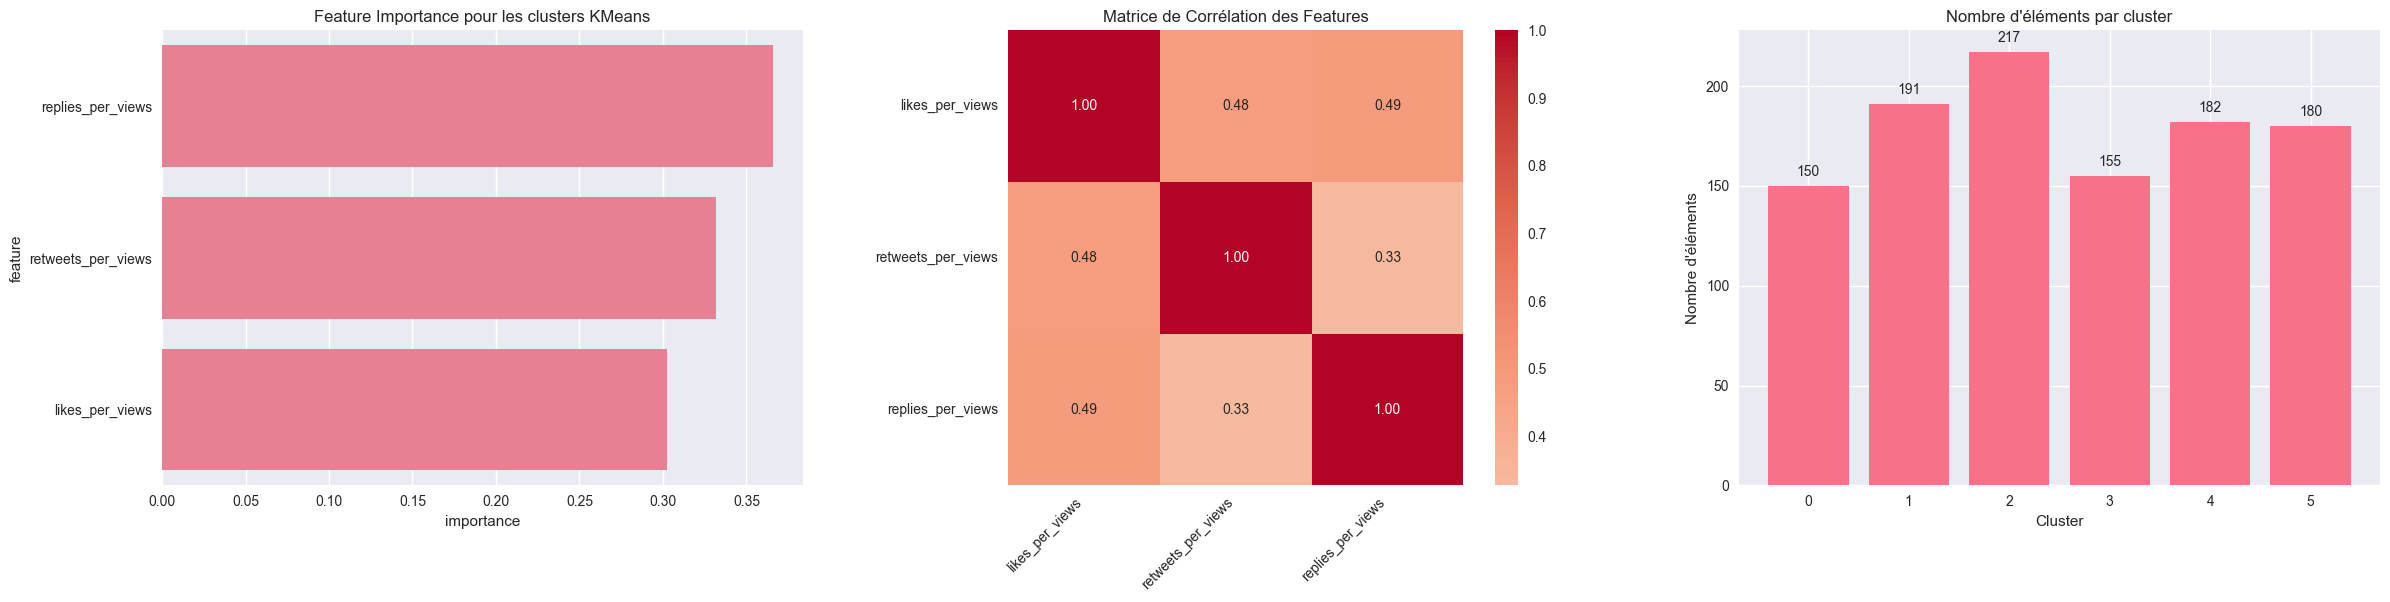

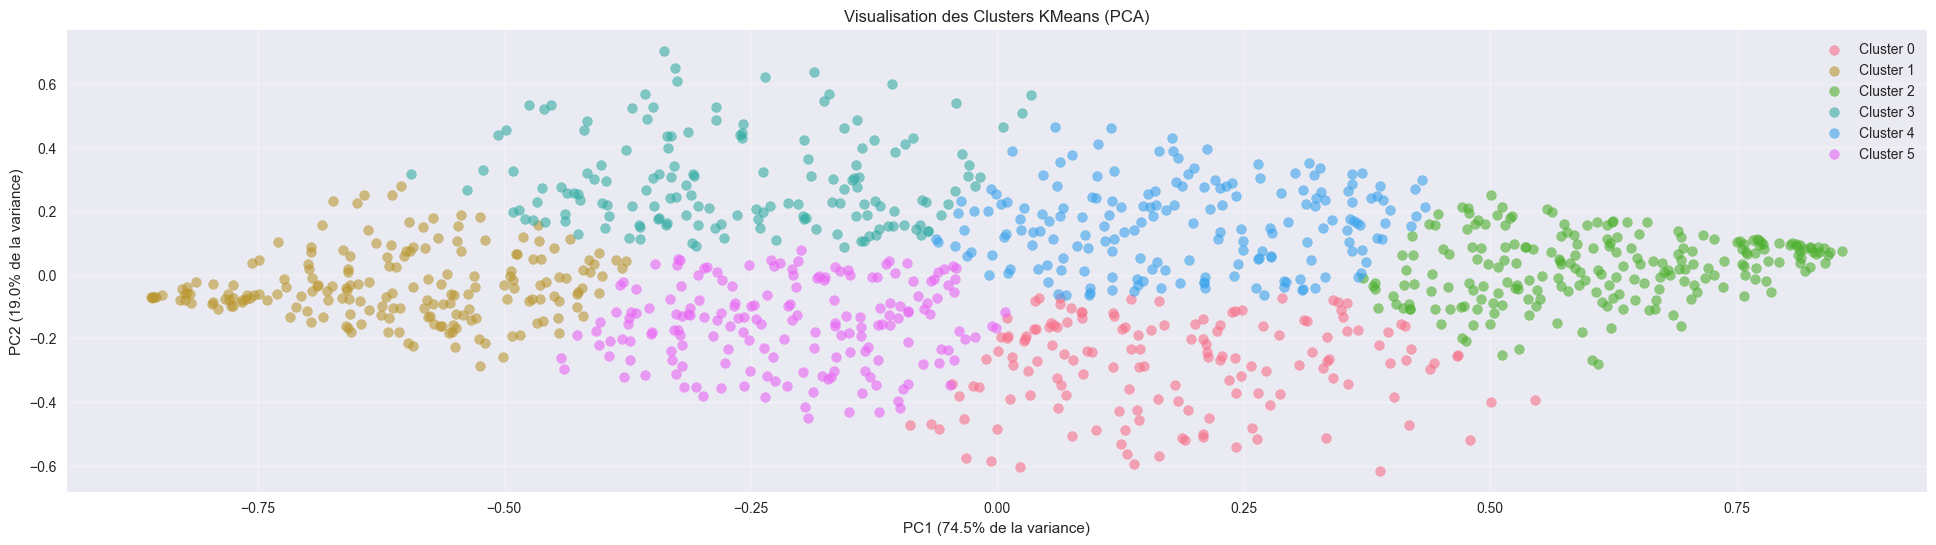


Test avec 7 clusters



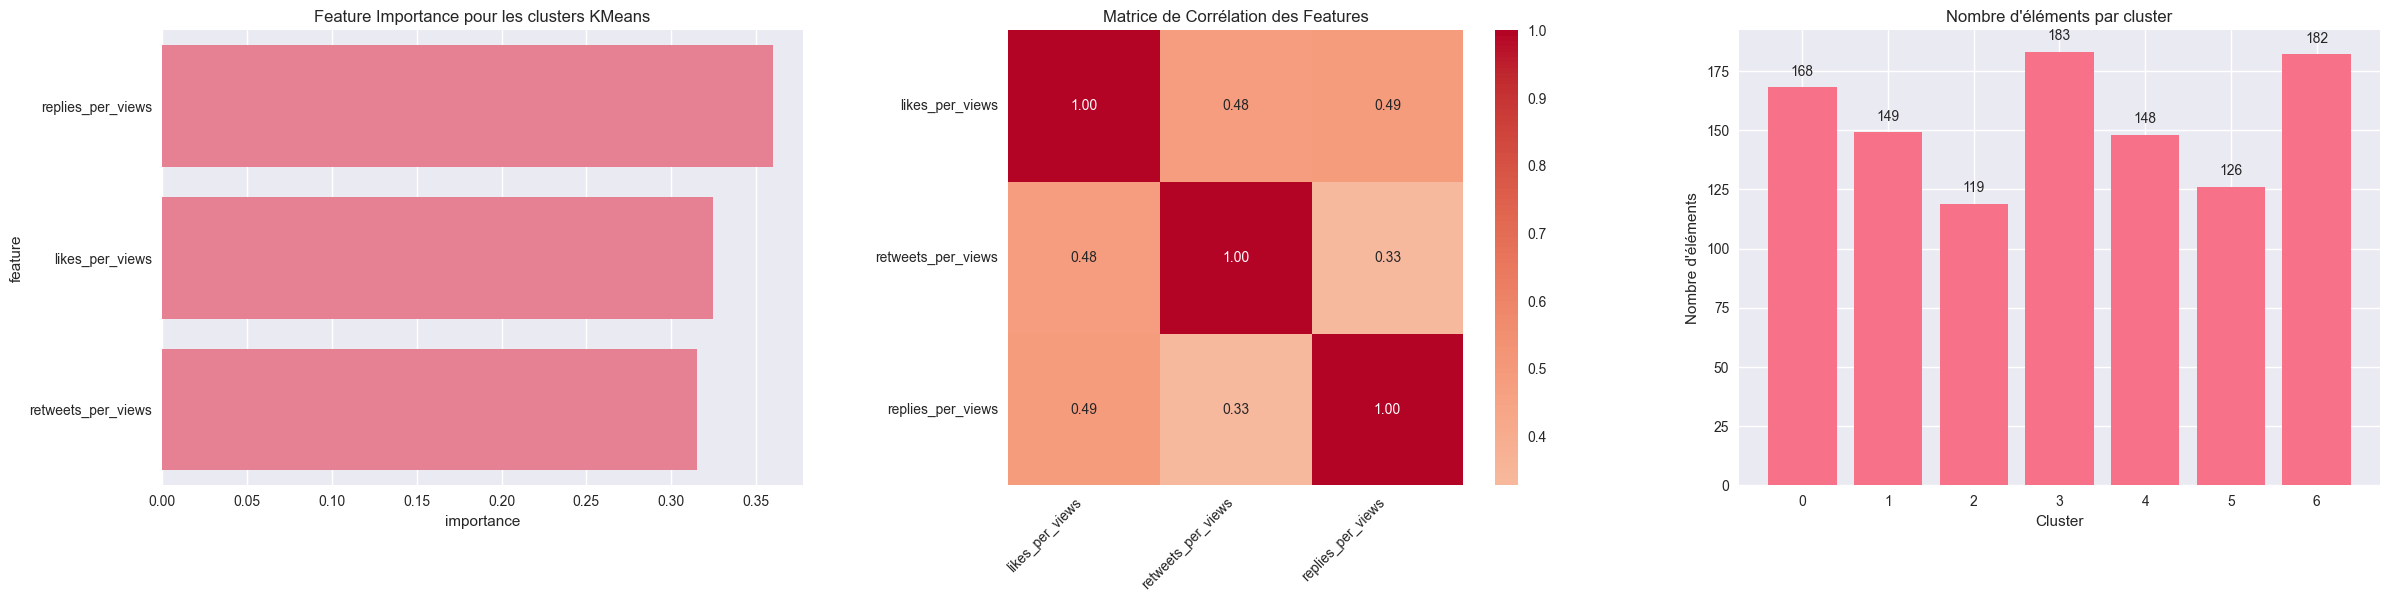

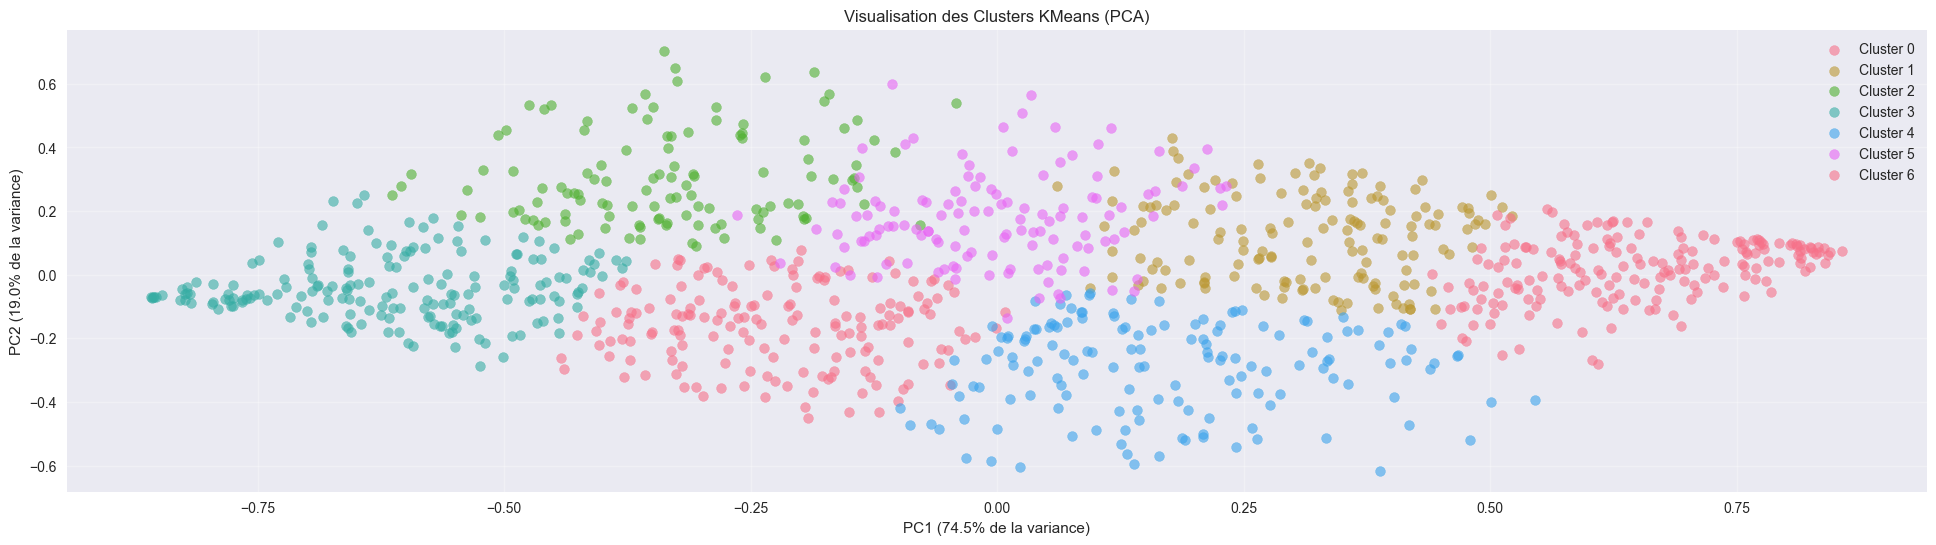


Test avec 8 clusters



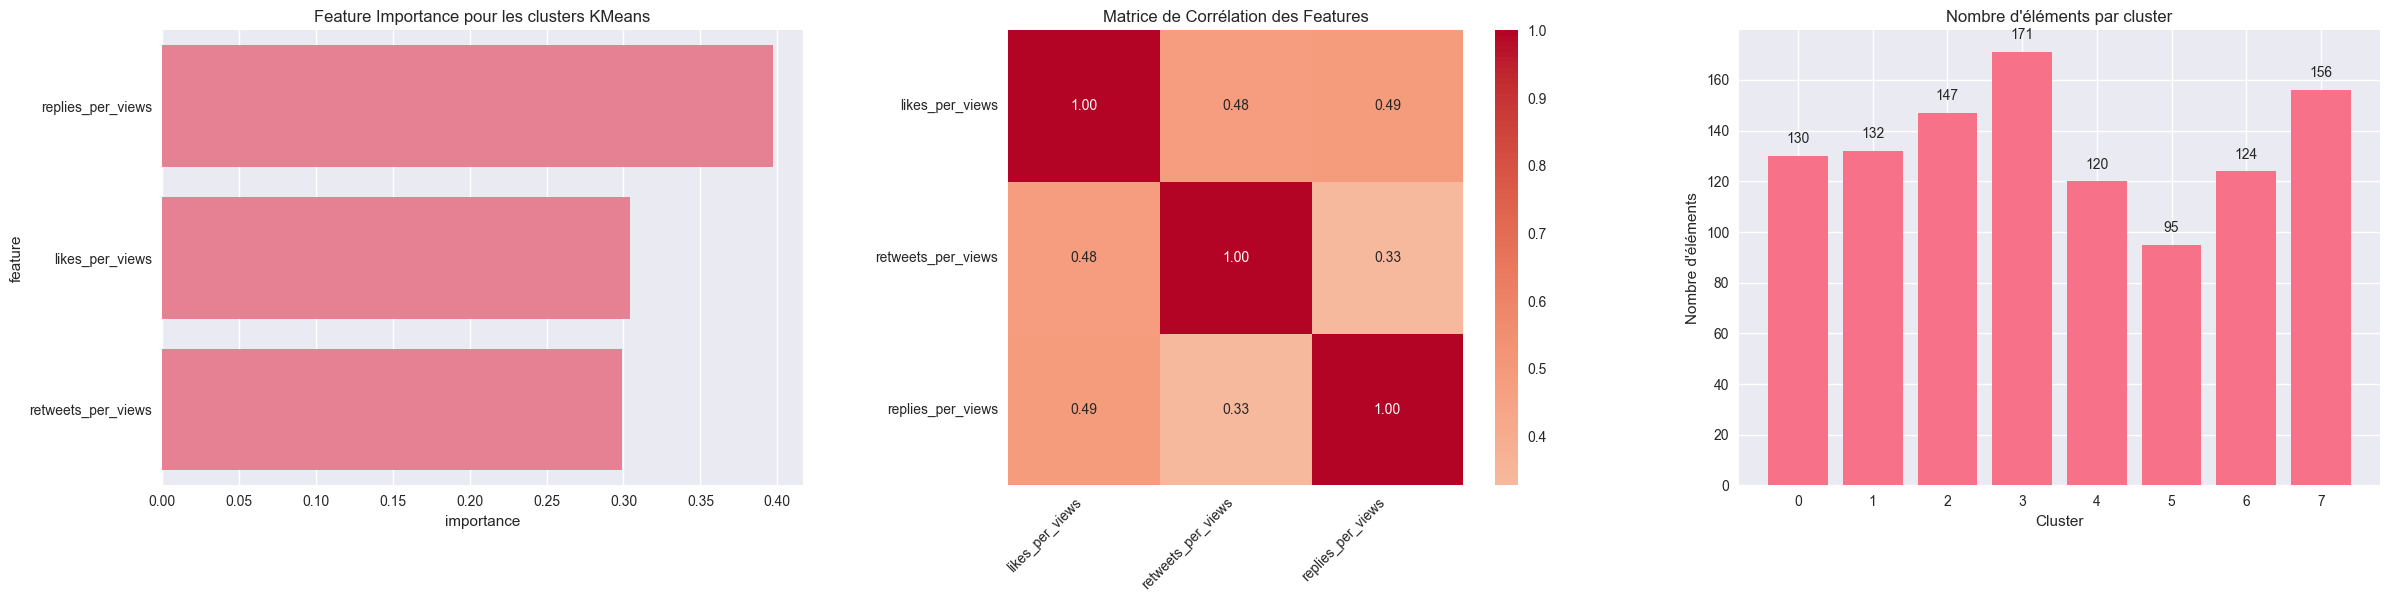

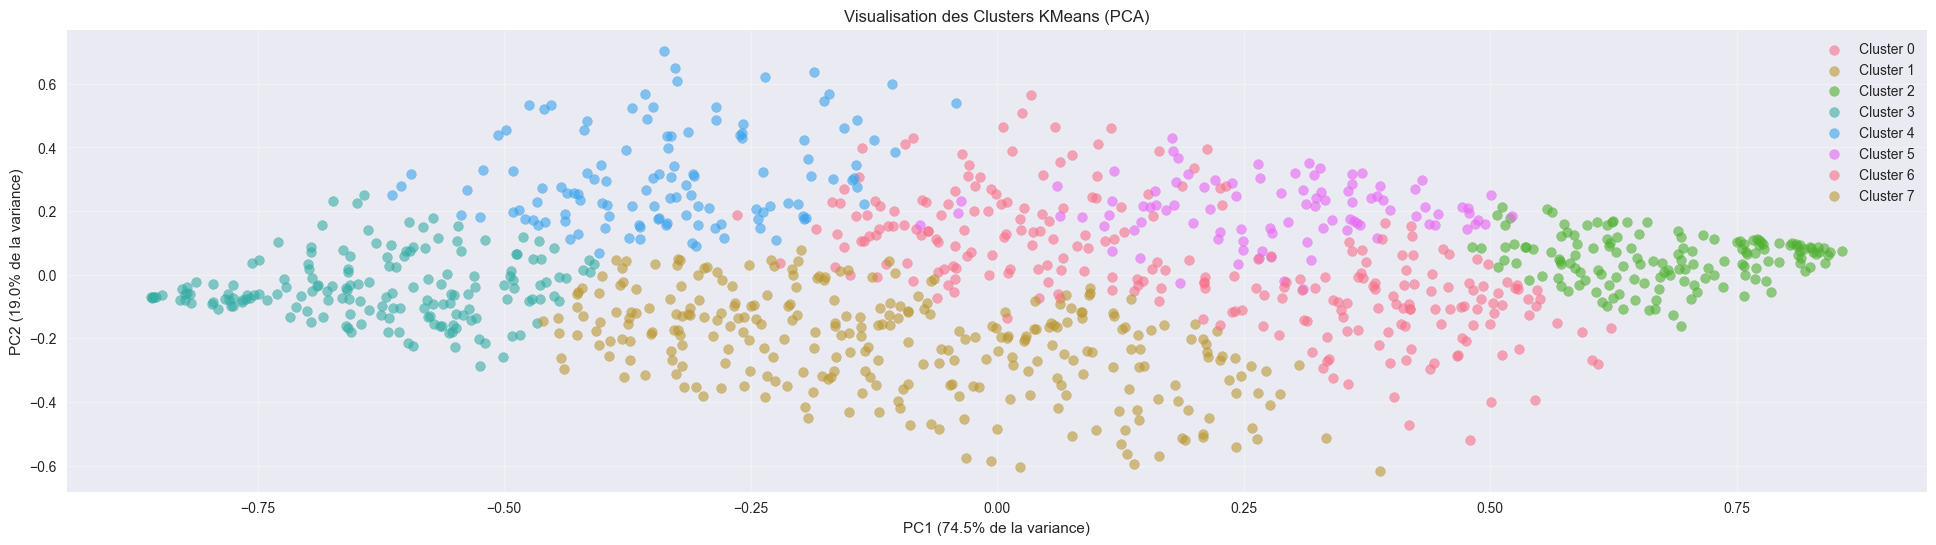


Test avec 9 clusters



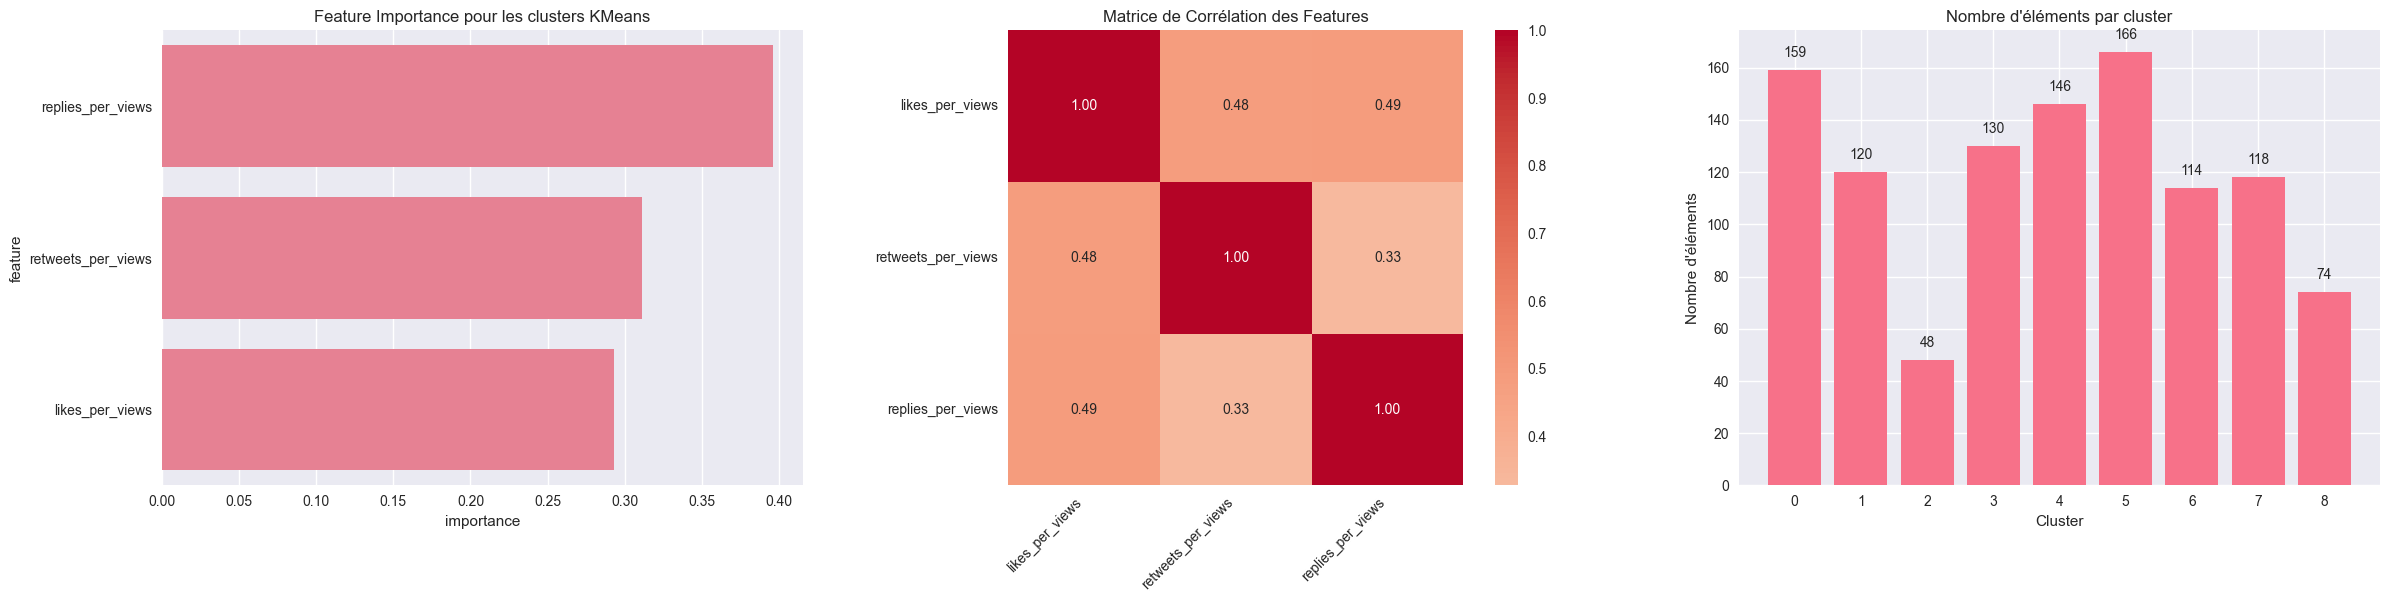

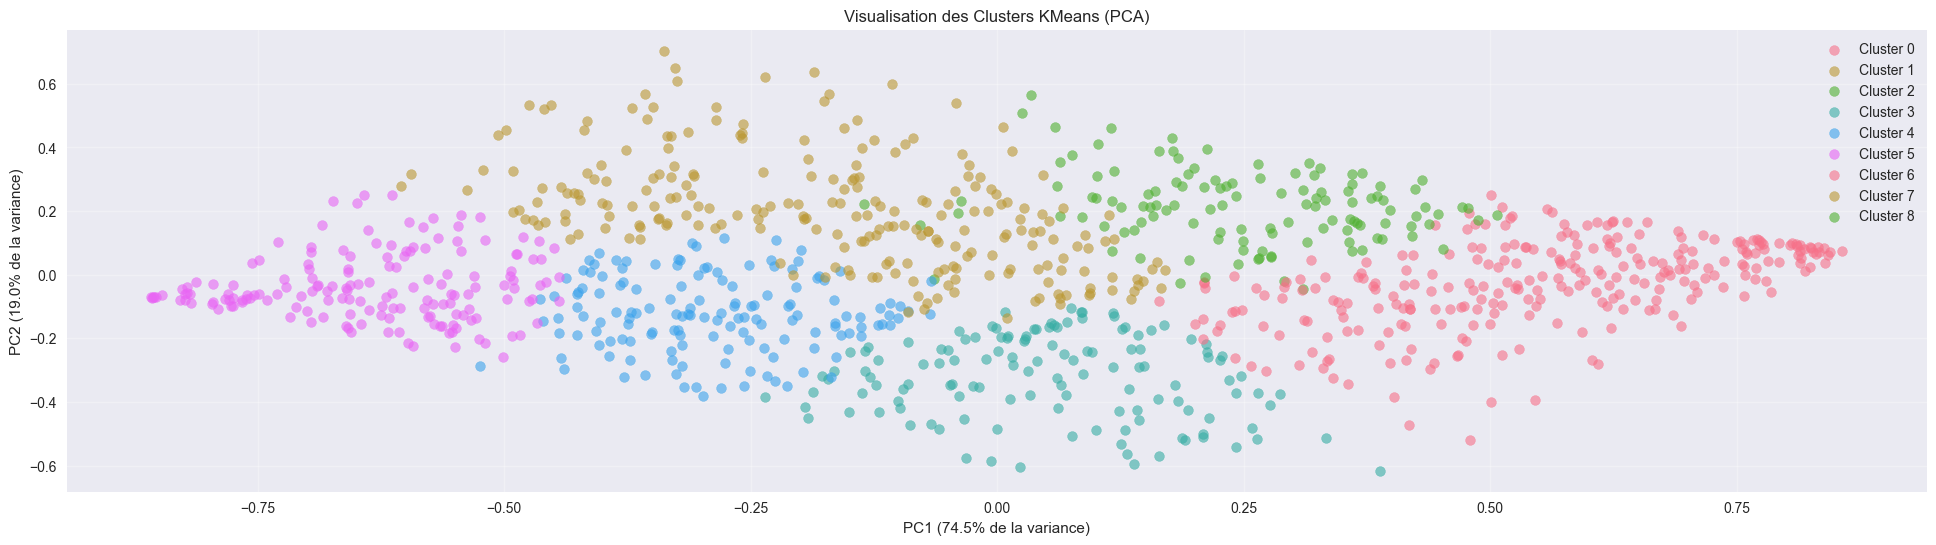

In [12]:
df_features = df_filtered.copy()

print("\n📈 Features d'engagement créées:")
print(df_features[features].describe())

n_clusters = 7

# Extraction des caractéristiques
X = df_features[features]

# Normalisation des données
scaler = QuantileTransformer() # StandarScaler, RobustScaler, QuantileTransformer, PowerTransformer
X_scaled = scaler.fit_transform(X)

# Visualiser les clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Méthode Elbow
inertias = []

# Métohde Silhouette
silhouette_scores = []

k_range = range(2, 10)
metrics = {
    'inertia': [],
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

models = {}

# Testez différents K visuellement
for k in k_range:
    print(f"\nTest avec {k} clusters\n")

    # Effectuer le clustering KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Calcul des métriques
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_scaled, cluster_labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_scaled, cluster_labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_scaled, cluster_labels))

    # Ajouter les clusters au DataFrame original
    df_features["cluster"] = cluster_labels

    # Store model and data for this k value in the models dictionary
    models[k] = {
        'model': kmeans,
        'labels': cluster_labels,
        'df_features': df_features.copy()  # Store a copy of the dataframe with cluster assignments
    }

    # Calculer l'importance des features via RandomForest sur les clusters
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_scaled, cluster_labels)
    importances_f = rf_model.feature_importances_

    # Créer un DataFrame pour visualiser l'importance des features
    feature_importance_df = pd.DataFrame({
        "feature": features,
        "importance": importances_f
    }).sort_values(by="importance", ascending=False)

    # Créer une figure avec 3 subplots alignés horizontalement
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # 1. Visualiser l'importance des features
    sns.barplot(x="importance", y="feature", data=feature_importance_df, ax=axes[0])
    axes[0].set_title("Feature Importance pour les clusters KMeans")
    
    # 2. Matrice de corrélation
    correlation_matrix = df_features[features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', ax=axes[1])
    axes[1].set_title('Matrice de Corrélation des Features')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, ha='right')
    
    # 3. Nombre d'éléments par cluster
    cluster_counts = df_features['cluster'].value_counts().sort_index()
    bars = axes[2].bar(range(len(cluster_counts)), cluster_counts.values)
    axes[2].set_title('Nombre d\'éléments par cluster')
    axes[2].set_xticks(range(len(cluster_counts)))
    axes[2].set_xticklabels(cluster_counts.index)
    axes[2].set_xlabel('Cluster')
    axes[2].set_ylabel('Nombre d\'éléments')
    for i, count in enumerate(cluster_counts.values):
        axes[2].text(i, count + 5, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Visualisation PCA des clusters dans une figure séparée
    plt.figure(figsize=(24, 6))
    for i in range(k):
        mask = df_features['cluster'] == i
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=f'Cluster {i}', alpha=0.6, s=50)

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} de la variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} de la variance)')
    plt.title('Visualisation des Clusters KMeans (PCA)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

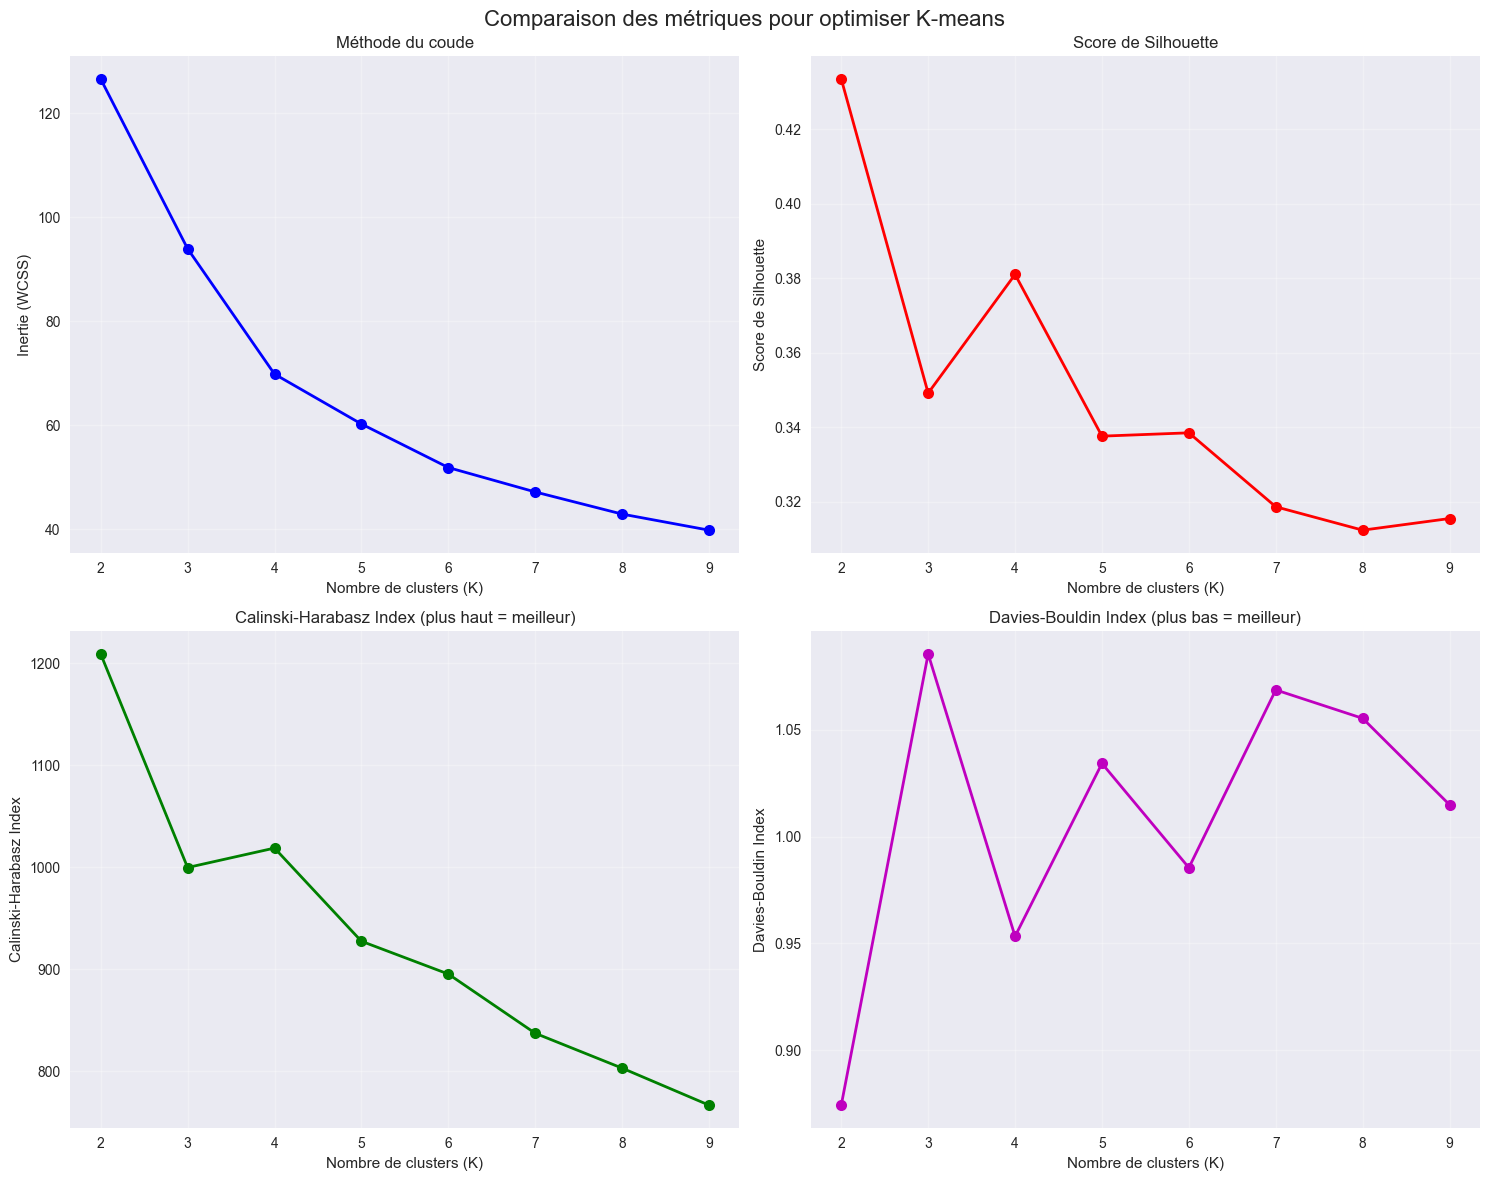


INTERPRÉTATION DES MÉTRIQUES :
- Elbow (Inertie) : Détection d'un coude
- Silhouette Score : [0, 1] - Plus proche de 1 = meilleur
- Calinski-Harabasz : [0, +∞] - Plus haut = meilleur
- Davies-Bouldin : [0, +∞] - Plus bas = meilleur


In [13]:
# Création des graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparaison des métriques pour optimiser K-means', fontsize=16)

# 1. Méthode du coude (Inertie)
axes[0, 0].plot(k_range, metrics['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Nombre de clusters (K)')
axes[0, 0].set_ylabel('Inertie (WCSS)')
axes[0, 0].set_title('Méthode du coude')
axes[0, 0].grid(True, alpha=0.3)

# 2. Score de Silhouette
axes[0, 1].plot(k_range, metrics['silhouette'], 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Nombre de clusters (K)')
axes[0, 1].set_ylabel('Score de Silhouette')
axes[0, 1].set_title('Score de Silhouette')
axes[0, 1].grid(True, alpha=0.3)

# 3. Calinski-Harabasz Index
axes[1, 0].plot(k_range, metrics['calinski_harabasz'], 'go-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Nombre de clusters (K)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index (plus haut = meilleur)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Davies-Bouldin Index
axes[1, 1].plot(k_range, metrics['davies_bouldin'], 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Nombre de clusters (K)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].set_title('Davies-Bouldin Index (plus bas = meilleur)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interprétation des métriques
print("\n" + "="*50)
print("INTERPRÉTATION DES MÉTRIQUES :")
print("="*50)
print("- Elbow (Inertie) : Détection d'un coude")
print("- Silhouette Score : [0, 1] - Plus proche de 1 = meilleur")
print("- Calinski-Harabasz : [0, +∞] - Plus haut = meilleur")
print("- Davies-Bouldin : [0, +∞] - Plus bas = meilleur")

# Evaluation du modèle

In [22]:
# Analyse des clusters
k_selected = 4
df_features_selected = models[k_selected]['df_features']

print(f"\n🎯 Résultats du clustering (k={k_selected}):")
cluster_means = df_features_selected.groupby('cluster')[features].mean()
print("\n📋 Profil moyen des clusters:")

# Sauvegarder cluster_means
MODEL_DIR = "../models/engagement_kmeans"
os.makedirs(MODEL_DIR, exist_ok=True)
cluster_means_path = os.path.join(MODEL_DIR, "cluster_means.csv")
cluster_means.to_csv(cluster_means_path, index=True)
print(f"✅ Cluster means sauvegardées dans: {cluster_means_path}")
print("\n📋 Données sauvegardées:")
cluster_means


🎯 Résultats du clustering (k=4):

📋 Profil moyen des clusters:
✅ Cluster means sauvegardées dans: ../models/engagement_kmeans/cluster_means.csv

📋 Données sauvegardées:


,likes_per_views,retweets_per_views,replies_per_views
cluster,,,
0,0.033930,0.014299,0.008308
1,0.005840,0.001045,0.000909
2,0.010257,0.001807,0.003619
3,0.017619,0.004693,0.001296


In [15]:
cluster_dfs = {}
for k in range(k_selected):
    cluster_dfs[f'Cluster {k}'] = df_features_selected[df_features_selected['cluster'] == k]['screen_name'].reset_index(drop=True)
display(pd.concat(cluster_dfs, axis=1).head(10))

display(df_features_selected[df_features_selected['name'] == 'Bitcoin'][
    ['screen_name', 'cluster'] + [f for f in features]
])


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,SuiNetwork,ethereum,BNBCHAIN,Bitcoin
1,bitgetglobal,Tether_to,solana,chainlink
2,PiCoreTeam,Ripple,trondao,StellarOrg
3,eth_classic,circle,ton_blockchain,avax
4,kucoincom,dogecoin,litecoin,hedera
5,Four_FORM_,Cardano,Polkadot,monero
6,injective,HyperliquidX,Uniswap,pepecoineth
7,bonk_inu,bitfinex,aave,opentensor
8,dogwifcoin,Shibtoken,Aptos,cronos_chain
9,Immutable,ethena_labs,okx,KaspaCurrency


,screen_name,cluster,likes_per_views,retweets_per_views,replies_per_views
0,Bitcoin,3,0.015097,0.003478,0.001752


## Labelisation

In [16]:
# Chargement dynamique du dictionnaire
cluster_dict = getattr(clusters, f'engagement_clusters_{k_selected}', None)

print(json.dumps(cluster_dict, indent=2, ensure_ascii=False).replace('\\n', '\n'))

{
  "0": {
    "cluster_label": "Haute Viralité",
    "cluster_color": "🔵",
    "cluster_description": "
            Comptes avec les ratios d'engagement les plus élevés, particulièrement en retweets.
            "
  },
  "1": {
    "cluster_label": "Faible Engagement",
    "cluster_color": "🔴",
    "cluster_description": "
            Profils avec les ratios d'engagement les plus bas sur tous les indicateurs.
            "
  },
  "2": {
    "cluster_label": "Engagement Équilibré",
    "cluster_color": "🟡",
    "cluster_description": "
            Profils avec un engagement modéré et bien réparti entre likes, retweets et replies.
            "
  },
  "3": {
    "cluster_label": "Forte Attraction",
    "cluster_color": "🟢",
    "cluster_description": "
            Comptes générant beaucoup de likes mais peu de replies, suggérant un contenu populaire mais moins propice au débat.
            "
  }
}


In [17]:

if cluster_dict is None:
    raise ValueError(f"Aucun dictionnaire trouvé pour {k_selected} clusters")

def assign_engagement_labels(df_clustered):
    """
    Ajoute une colonne 'engagement_level' au DataFrame avec les labels correspondants aux clusters
    """

    # Créer une copie du DataFrame pour éviter de modifier l'original
    result_df = df_clustered.copy()
    
    # Ajouter la colonne engagement_level
    result_df['engagement_level'] = result_df['cluster'].apply(
        lambda x: cluster_dict.get(x, {}).get("cluster_label", "Cluster Inconnu")
    )
    
    return result_df

df_features_selected = assign_engagement_labels(df_features_selected)

df_features_selected.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,...,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered,likes_per_views,retweets_per_views,replies_per_views,bookmarks_per_views,cluster,engagement_level
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7856996,13,28760,"{""tweet-1947676712256352511"": {""created_at"": ""...",1313643968,...,1753197478,{'tweet-1947676712256352511': {'created_at': '...,20,17,0.015097,0.003478,0.001752,0.000495,3,Forte Attraction
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3885892,0,4385,"{""tweet-1947426361519575517"": {""created_at"": ""...",1390763724,...,1753197715,{'tweet-1947413177131798789': {'created_at': '...,16,5,0.010334,0.001641,0.000856,0.000628,1,Faible Engagement
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,539029,246,1763,"{""tweet-1943672677358506462"": {""created_at"": ""...",1415394150,...,1752314758,{'tweet-1943672677358506462': {'created_at': '...,20,9,0.004769,0.000994,0.000816,0.000272,1,Faible Engagement
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3154929,987,9120,"{""tweet-1943810539412435185"": {""created_at"": ""...",1356983139,...,1752314783,{'tweet-1943810539412435185': {'created_at': '...,20,7,0.008579,0.002270,0.000332,0.000397,1,Faible Engagement
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3859567,629,27214,"{""tweet-1943943436886757550"": {""created_at"": ""...",1539759563,...,1752314808,{'tweet-1943943436886757550': {'created_at': '...,17,16,0.006359,0.001659,0.004532,0.000182,2,Engagement Équilibré


In [18]:
# ANALYSE DES COMPTES REPRÉSENTATIFS
 
print("\n🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:")

engagement_clusters = [v["cluster_label"] for v in cluster_dict.values()]

for engagement_level in engagement_clusters:
    print(f"\n--- {engagement_level.upper()} ---")
    subset = df_features_selected[df_features_selected['engagement_level'] == engagement_level]
    
    # Statistiques du groupe
    print(f"Nombre de comptes: {len(subset)}")
    print(f"Followers moyen: {subset['followers_count'].mean():.0f}")
    
    # Top 3 comptes du groupe
    top_accounts = subset.nlargest(3, 'cluster')[
        ['screen_name', 'followers_count'] + [f for f in features]
    ]
    print("Top 3 comptes:")
    print(top_accounts.to_string(index=False))


🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:

--- HAUTE VIRALITÉ ---
Nombre de comptes: 310
Followers moyen: 244645
Top 3 comptes:
 screen_name  followers_count  likes_per_views  retweets_per_views  replies_per_views
  SuiNetwork          1109607         0.017197            0.002775           0.003540
bitgetglobal          4564210         0.011589            0.006935           0.008314
  PiCoreTeam          4342056         0.017765            0.003651           0.003037

--- FAIBLE ENGAGEMENT ---
Nombre de comptes: 281
Followers moyen: 793370
Top 3 comptes:
screen_name  followers_count  likes_per_views  retweets_per_views  replies_per_views
   ethereum          3885892         0.010334            0.001641           0.000856
  Tether_to           539029         0.004769            0.000994           0.000816
     Ripple          3154929         0.008579            0.002270           0.000332

--- ENGAGEMENT ÉQUILIBRÉ ---
Nombre de comptes: 239
Followers moyen: 340478
Top 3 comptes:
screen_nam

# Sauvegarde du modèle

In [19]:
MODEL_DIR = "../models/engagement_kmeans"
os.makedirs(MODEL_DIR, exist_ok=True)

# Sauvegarde des objets
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.joblib"))
joblib.dump(models[k_selected]["model"], os.path.join(MODEL_DIR, "kmeans.joblib"))
print(f"Model and scaler saved to {MODEL_DIR}")

Model and scaler saved to ../models/engagement_kmeans


# Test du model sauvegardé

In [20]:
# 1. Charger le scaler et le modèle
scaler = joblib.load(os.path.join(MODEL_DIR, "scaler.joblib"))
kmeans = joblib.load(os.path.join(MODEL_DIR, "kmeans.joblib"))

# 2. Appliquer le même pipeline sur de nouvelles données
df_new = pd.DataFrame({
    'total_views': [100000, 200000, 1428758704],
    'likes_per_views': [0.002, 0.005, 0.00604],
    'retweets_per_views': [0.005, 0.002, 0.000783],
    'replies_per_views': [0.001, 0.003, 0.000603],
})

X_new = df_new[features]  # mêmes features que lors de l'entraînement
X_new_scaled = scaler.transform(X_new)  # important : utiliser transform(), PAS fit_transform()
predicted_labels = kmeans.predict(X_new_scaled)
df_new["predicted_cluster"] = predicted_labels

df_new

,total_views,likes_per_views,retweets_per_views,replies_per_views,predicted_cluster
0,100000,0.00200,0.005000,0.001000,1
1,200000,0.00500,0.002000,0.003000,2
2,1428758704,0.00604,0.000783,0.000603,1
